<a href="https://colab.research.google.com/github/HasibAlMuzdadid/Machine-Learning-and-Deep-Learning-Projects/blob/main/planar%20data%20classification%20%5Bsingle%20hidden%20layer%20logistic%20regression%5D/planar_data_classification_using_single_hidden_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Planar data classification with one hidden layer**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import sklearn
import sklearn.linear_model

In [ ]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400                                                                 # number of examples
    N = int(m/2)                                                            # number of points per class
    D = 2                                                                   # dimensionality
    X = np.zeros((m,D))                                                     # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8')                                      # labels vector (0 for red, 1 for blue)
    a = 4                                                                   # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2       # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2                          # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

In [ ]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

In [ ]:
def sigmoid(x):
    
    s = 1/(1+np.exp(-x))
    return s

In [ ]:
# Load Dataset
X, Y = load_planar_dataset()

In [ ]:
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]

print(f"The shape of X is {shape_X}")
print(f"The shape of Y is {shape_Y}")
print(f"Quantity of training examples are: {m}")


The shape of X is (2, 400)
The shape of Y is (1, 400)
Quantity of training examples are: 400


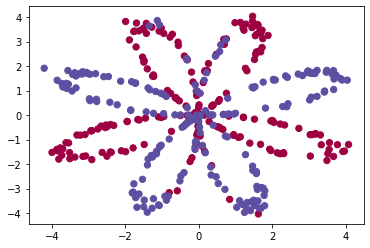

In [ ]:
# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);
# The data looks like a "flower" with some red (label y=0) and some blue (label y=1) points

Before building a full neural network, let's see how simple logistic regression performs on this problem

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of simple logistic regression: 47.0 % (percentage of correctly labelled datapoints)


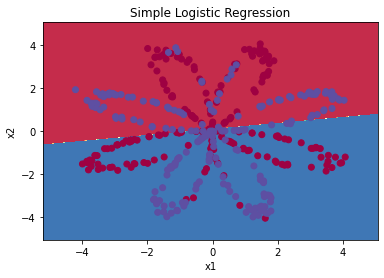

In [ ]:
# Train simple logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)

# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Simple Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print (f"Accuracy of simple logistic regression: {float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100)} % (percentage of correctly labelled datapoints)")

The dataset is not linearly separable, so simple logistic regression doesn't perform well. A neural network will do better

The general methodology to build a Neural Network is:

*   Defining neural network structure ( no. of input units,  no. of hidden units etc) 
*   Initializing the model's parameters
*   Loop:
     *   Implementing forward propagation
     *   Computing loss
     *   Implementing backward propagation to get the gradients
     *   Updating parameters (gradient descent)


**Forward Propagation Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}$$

Given the predictions on all the examples, we can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small $$


In [ ]:
# Initializing layer sizes
def layer_sizes(X, Y, n_h):  
  n_x = X.shape[0]
  n_h = n_h                          # hidden layer size 
  n_y = Y.shape[0]
     
  return (n_x, n_h, n_y)

In [ ]:
# Initializing parameters

def initialize_parameters(n_x, n_h, n_y):
  W1 = np.random.randn(n_h,n_x)*0.01
  b1 = np.zeros((n_h,1))
  W2 = np.random.randn(n_y,n_h)*0.01
  b2 = np.zeros((n_y,1))

  parameters = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2}
    
  return parameters

In [ ]:
# Forward Propagation

def forward_propagation(X, parameters):
  # Retrieve each parameter from the dictionary "parameters"
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]

  # Implement Forward Propagation to calculate A2 (probabilities)
  Z1 = np.dot(W1,X)+b1
  A1 = np.tanh(Z1)
  Z2 = np.dot(W2,A1)+b2
  A2 = sigmoid(Z2)

  cache = {"Z1": Z1,
          "A1": A1,
          "Z2": Z2,
          "A2": A2}
    
  return A2, cache

In [ ]:
# Computing Cost

def compute_cost(A2, Y):
  m = Y.shape[1]           # number of examples
  logprobs = np.multiply(Y,np.log(A2))+np.multiply((1-Y),np.log(1-A2))
  cost = -(1/m)*np.sum(logprobs)

  cost = float(np.squeeze(cost))    # making sure that cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    
  return cost

In [ ]:
# Backward Propagation

def backward_propagation(parameters, cache, X, Y):
  m = X.shape[1]

  W1 = parameters["W1"]     # retrieving W1 and W2 from the dictionary "parameters"
  W2 = parameters["W2"]

  A1 = cache["A1"]          # retrieving A1 and A2 from dictionary "cache"
  A2 = cache["A2"]

  # Backward propagation: calculate dW1, db1, dW2, db2
  dZ2 = A2-Y
  dW2 = (1/m)*np.dot(dZ2,A1.T)
  db2 = (1/m)*np.sum(dZ2,keepdims=True,axis=1)
  dZ1 = np.dot(W2.T,dZ2)*(1-np.power(A1,2))
  dW1 = (1/m)*np.dot(dZ1,X.T)
  db1 = (1/m)*np.sum(dZ1,axis=1,keepdims=True) 

  grads = {"dW1": dW1,
           "db1": db1,
           "dW2": dW2,
           "db2": db2}
    
  return grads 

In [ ]:
# Update Parameters

def update_parameters(parameters, grads, learning_rate):
  
  W1 = copy.deepcopy(parameters["W1"])           # retrieving a copy of each parameter from the dictionary "parameters" by using copy.deepcopy() for W1 and W2
  b1 = parameters["b1"]
  W2 = copy.deepcopy(parameters["W2"])
  b2 = parameters["b2"]

  dW1 = grads["dW1"]                # retrieving each gradient from the dictionary "grads"
  db1 = grads["db1"]
  dW2 = grads["dW2"]
  db2 = grads["db2"]

  W1 = W1-learning_rate*dW1           # Update rule for each parameter
  b1 = b1-learning_rate*db1
  W2 = W2-learning_rate*dW2
  b2 = b2-learning_rate*db2

  parameters = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2}
    
  return parameters

In [ ]:
# Final Neural Network Model

def nn_model(X, Y, n_h, num_iterations, print_cost):
  
  n_x = layer_sizes(X, Y, n_h)[0]
  # n_h = layer_sizes(X, Y, n_h)[1]
  n_y = layer_sizes(X, Y, n_h)[2]
  
  parameters = initialize_parameters(n_x, n_h, n_y)    # Initializing parameters

  for i in range(0, num_iterations):
    
    A2, cache = forward_propagation(X, parameters)
    cost = compute_cost(A2, Y)
    grads = backward_propagation(parameters, cache, X, Y)
    parameters = update_parameters(parameters, grads, learning_rate=1.2)

    # Print the cost every 1000 iterations
    if (print_cost == True) and (i % 1000 == 0):      
      print (f"Cost after iteration {i} : {cost}")

  return parameters

In [ ]:
# Predict

def predict(parameters, X):

  A2, cache=forward_propagation(X, parameters)                   # Computing probabilities using forward propagation and classifying to 0/1 using 0.5 as the threshold
  predictions = A2>0.5

  return predictions

Cost after iteration 0 : 0.6931125167719424
Cost after iteration 1000 : 0.28257810627095964
Cost after iteration 2000 : 0.26977714894121974
Cost after iteration 3000 : 0.26231806209753844
Cost after iteration 4000 : 0.24122763763977198
Cost after iteration 5000 : 0.22602306763242702
Cost after iteration 6000 : 0.2216209603140178
Cost after iteration 7000 : 0.21890721724721862
Cost after iteration 8000 : 0.21688489461015498
Cost after iteration 9000 : 0.21525972814605296
Cost after iteration 10000 : 0.2179402893520276


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

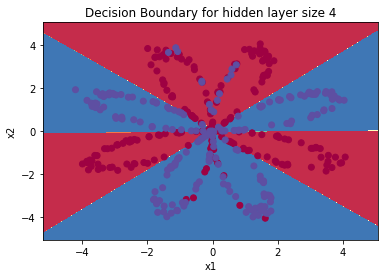

In [ ]:
## Testing

# Building a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10001, print_cost=True)

# Ploting the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title(f"Decision Boundary for hidden layer size 4")


In [ ]:
# Accuracy
predictions = predict(parameters, X)
print (f"Accuracy: {float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)} %")

Accuracy: 90.5 %


**Tuning hidden layer size**

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 90.5 %
Accuracy for 20 hidden units: 91.0 %
Accuracy for 50 hidden units: 91.0 %


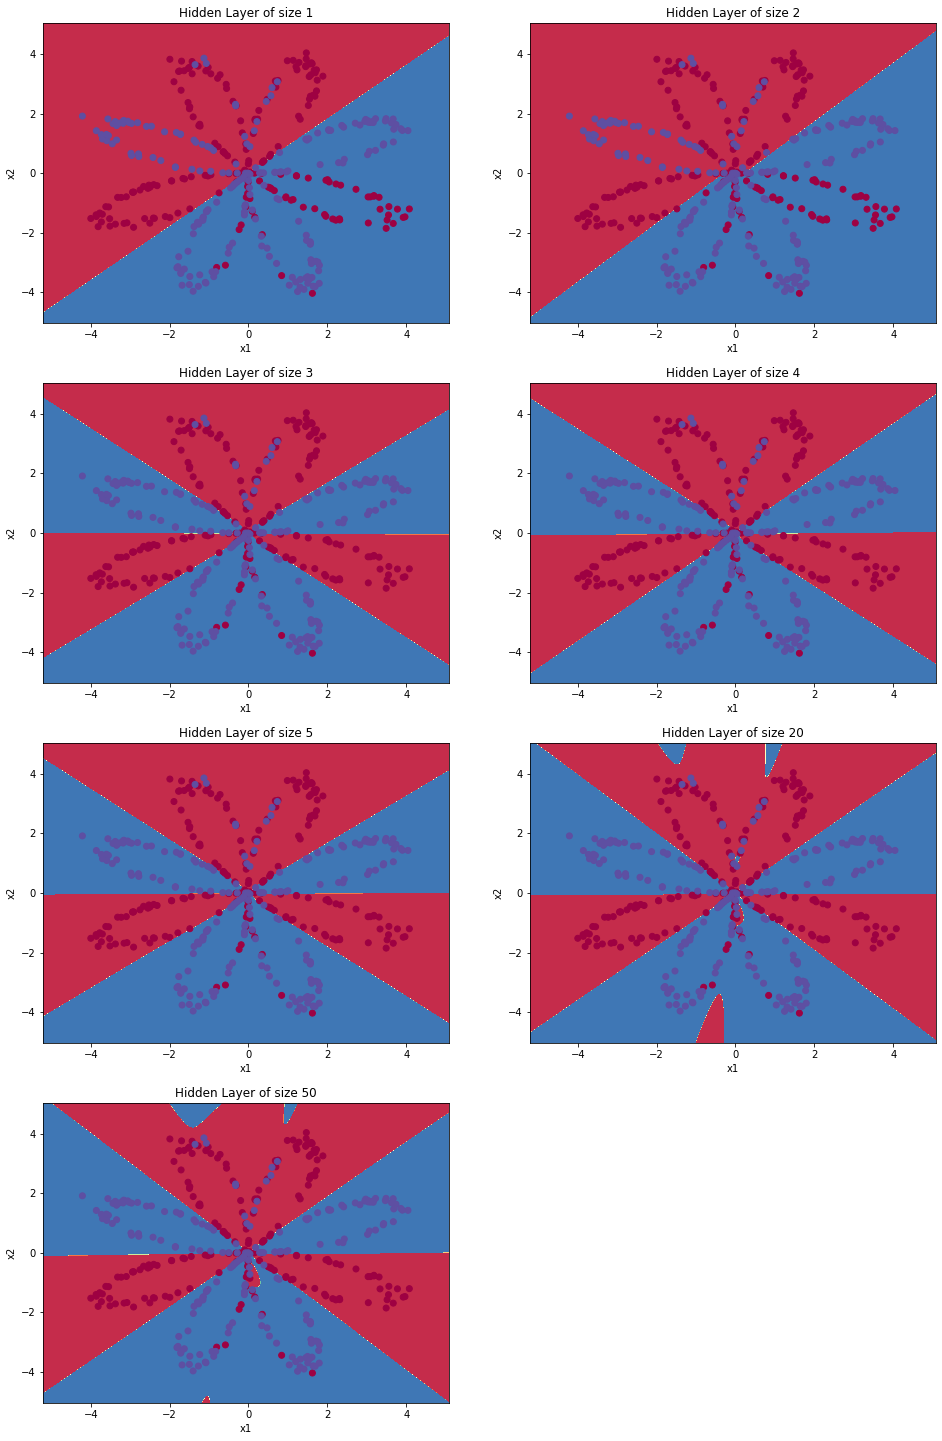

In [ ]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title(f"Hidden Layer of size {n_h}")
    parameters = nn_model(X, Y, n_h, num_iterations = 5001, print_cost=False)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print (f"Accuracy for {n_h} hidden units: {accuracy} %")